# Great Lunar Lander with DQN

**The Team:**
* Class: DAAA/FT/2B/06
* **Member 1**:
    * Name: Haja Amir Rahman
* **Member 2**:
    * Name: Justin Wong

# OpenAI: Lunar Lander V2

<img src="https://miro.medium.com/max/1400/1*W1t--mEISwFTJNXi-qk7vw.png" width="500">

Image from Medium

# Goal of Notebook
The goal of the notebook is to create a Reinforcement Learning model that can land an agent in the Lunar Lander gym environment.





**Exanple Application of Reinforcement Learning**



**Reinforcement Learning**

Reinforcement Learning or RL is subset of machine learning that deals with how an agent in an environment choose a sequence of actions in order to maximise a numerical reward signal. It can also be said that RL is trying to find a balance between exploration and exploitation. Exploration is a type of decision where the agent chooses to pick an action that it would not have done. In contrast, exploitation is when the agent follows what it has always done.
<img src="https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/fsd-1632704256.jpg" width="500">

**Self-driving cars:** Since the invention of cars, people have always dreamed a future where cars could drive on its own and they do not need to worry about driving until they reach their desired destination. This futuristic idea is comming true very soon thanks to the help of Reinforcement Learning. In case of self-driving car, the agent would be the car itself while the environment is the roads along with other vehicles, pedestrians etc. The recent advancements of Reinfocement Learning in such a difficult and complex environment has allows us to inch closer and closer a self-driving car future.

**OpenAI GYM**

OpenAI GYM is a toolkit for developing and comparing reinforcement learning algorithms. They have a gym library that contains a variety of reinforcement learning tasks from walking in 3D space to playing arcade games like PacMan. These environments have a shared and easy-to-use interface where researchers and developers can train and compare agents using different algorithms.

**OpenAI Gym Environment: LunarLander-v2**

![gif](./gifs/1675422327.8682656/episode_2701.gif)

Lunar Lander is one of OpenAI's gym environment where the agent is a lunar lander that tries to land on a landing pad at coordinate (0,0). These coordinate are the first 2 numbers in the state vector.

There are a total of 4 discrete actions that the lander can do:

1. Do nothing
2. Fire left orientation engine
3. Fire main engine
4. Fire right orientation engine

There are a total of 8 observation space:

1. The coordinates of the lander in x
2. The coordinates of the lander in y
3. Its linear velocities in x
4. Its linear velocities in y
5. Its angle
6. Its angular velocity
7. If left leg is in contact with the ground
8. If right leg is in contact with the ground

Reward system of Lunar Lander:

* Moving from the top of the screen to the landing pad at zero speed can range from 100 to 140 points.
* If the lander moves away from the landing pad, it loses back the landing points.
* The episode finishes if the lander crashes (receives -100 points) or comes to a rest (receives 100 points).
* Each leg ground contact is an additional 10 points.
* Firing main engine -0.3 reward per step.

From the above, we can conclude that the best episode would be the one where the lander lands (**+20** for legs contact) and comes to rest (**+100** for rest) on the center of the landing pad at zero speed (**+140** for landing) with the least steps (**+200** - (count_main_engine_fire * 0.3)).

In [1]:
import gym
print(gym.__version__)

0.26.2


## Importing Libraries

In [2]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import wandb
import random
wandb.login()
wandb.init()
wandb.init(project="RL", entity="amirrahman19")
save_wandb = True
import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

env = gym.make('LunarLander-v2')
print(env.observation_space.shape)
print(env.action_space.n)
%env "WANDB_NOTEBOOK_NAME" "DQN-Amir.ipynb"

wandb: Currently logged in as: amirrahman19. Use `wandb login --relogin` to force relogin


(8,)
4
env: "WANDB_NOTEBOOK_NAME"="DQN-Amir.ipynb"


## Creating Q-Network

In [3]:


class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)
        
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
# LR = 0.01               # learning rate
UPDATE_EVERY = 7        # how often to update the target network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



## Creating Agent

In [4]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # wandb.log({'Loss': loss})
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



## Creating ReplayBuffer


In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)



## Creating GIF Function
### This is allows us to witness the progress of the agent every nth episode specified

In [6]:
from matplotlib import animation
import matplotlib.pyplot as plt
import gym 

"""
Ensure you have imagemagick installed with 
sudo apt-get install imagemagick
Open file in CLI with:
xgd-open <filelname>
"""
# def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

#     #Mess with this to change frame size
#     plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

#     patch = plt.imshow(frames[0])
#     plt.axis('off')

#     def animate(i):
#         patch.set_data(frames[i])

#     anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
#     anim.save(path + filename, writer='imagemagick', fps=60)

from PIL import Image

def save_frames_as_gif(frames, path, filename):
  im1 = Image.fromarray(frames[0])
  others = [Image.fromarray(i) for i in frames[1:]]
  im1.save(f'{path}/{filename}', save_all=True, append_images=others, duration=30, loop=0)


def gif(agent, path, filename):
  env = gym.make('LunarLander-v2', render_mode='rgb_array')
  state = env.reset()[0]
  frames = []

  for _ in range(2000):
    rendered = env.render()
    frames.append(rendered) 
    action = agent.act(state, 0)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state

    if done or truncated:
      env.close()
      save_frames_as_gif(frames, path, filename)
      return

### Creating DQN

Deep Q-Network or DQN in short was first proposed by the researchers in Google Deep Mind ([Mnih et al, 2013, 2015](https://www.nature.com/articles/nature14236?wm=book_wap_0005)) which was able to learn 49 different Atari 2600 games simply through a screen. Essentially, Deep Q-Network is a reinforcement learning algorithm that **combines Q-learning with deep neural networks**. This combination allows the agent to learn on complex and high dimensional environments such as video games.

**The Model**

For this notebook, when I create an instance of the DQN class, it will initialise the model and cloning it for the target model. Both models contains a Dense layer with 512 units with a ReLU activation with an input dimension equal to the **number of observation space** in the environment. Then, there is a hidden Dense layer with 256 units with a ReLu activation. This layer is then connected to a final Dense layer with the number of units equal to the number of **possible action space** for the agent. The model is compile with mean squared error with an Adam optimizer that has a configurable learning rate.

**Exploration and Exploitation Trade-off**

During training, for every step in every episode, there is a function that takes in the current state where the model will try to **estimate the q-values for each action** from the current state (Exploitation). However, there is a probability where if a randomly chosen number is lower than epsilon, a random action will be returned (i.e. Exploration).

**Experience Replay**

The returned action will be executed for that step which returns the next state, the reward for that step, whether the episode is done. These variables is then **stored as an experience** in a buffer. A buffer is where the agent keep records of all the state transitions it encountered so it can randomly sample and learn from them later. The memory-buffer used to store this is often referred to as Experience Replay.

**Bellman Equation**

After that, if there is enough experience, the model will sample some experiences for training. The model then use the Bellman Equation for the **model's target value**, where the expected return value is equal to the reward plus the discounted factor multiplied by the maximum value of the next state predicted by the target model. The state and the target value is then fitted into the model.

**Target Network**

The purpose of the target network is to **stabilize the training** of the model. This is because the target network prevents the training process from spiraling around. Since we are fixing the targets for multiple time steps, it allows the online network weights to move consistently towards the targets before an update. In our case, the frequency of updating the target network is configurable.

In [7]:
import time
import os

def calc_success_rate(scores, threshold=200.0):
    """Calculates the success rate based on a list of scores.

    Params
    ======
        scores (list): list of scores obtained by the agent
        threshold (float): the minimum score required for success

    Returns
    =======
        success_rate (float): the success rate of the agent
    """
    success = 0
    for score in scores:
        if score >= threshold:
            success += 1
    success_rate = success / len(scores)
    return success_rate

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    gif_folder = 'gifs/' + str(time.time())
    os.mkdir(gif_folder)
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    reward_window = deque(maxlen=100)  # last 100 rewards
    eps = eps_start                    # initialize epsilon
    
    
    print('starting training')
    for i_episode in range(1, n_episodes+1):
        states = []
        state = env.reset()[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            # print(f'{t=} ACTION', action)
            next_state, reward, done, *_ = env.step(action)
            states.append(next_state)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        reward_window.append(reward)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        scores.append(dict(
          episode=i_episode,
          epsilon=eps,
            average_score=np.mean(scores_window),
            success_rate=calc_success_rate(scores_window),
            average_reward=np.mean(reward_window)
            
        ))

        # saving GIF
        if i_episode % 100 == 1:
          gif(agent, path=gif_folder, filename=f'episode_{i_episode}.gif')
        
   
        
        wandb.log({'Episode': i_episode, 'Average Reward': np.mean(reward_window), 'Epsilon': eps,  'Average Score': np.mean(scores_window), 
                   'Success Rate': calc_success_rate(scores_window)})

        if np.mean(scores_window)>=250.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'saved_models/dqn.pth')
            break
    return scores


In [8]:
agent = Agent(state_size=8, action_size=4, seed=42)
scores = dqn(n_episodes=10000)



starting training
Episode 100	Average Score: -191.15
Episode 200	Average Score: -131.76
Episode 300	Average Score: -99.664
Episode 400	Average Score: -19.73
Episode 500	Average Score: -13.42
Episode 600	Average Score: 54.916
Episode 700	Average Score: 80.83
Episode 800	Average Score: 110.82
Episode 900	Average Score: 129.85
Episode 1000	Average Score: 159.14
Episode 1100	Average Score: 184.42
Episode 1200	Average Score: 195.95
Episode 1300	Average Score: 186.77
Episode 1400	Average Score: 170.35
Episode 1500	Average Score: 168.08
Episode 1600	Average Score: 139.96
Episode 1700	Average Score: 174.06
Episode 1800	Average Score: 147.89
Episode 1900	Average Score: 184.61
Episode 1943	Average Score: 180.27

KeyboardInterrupt: 

## Visualizing Final results
### Alternatively can refer to screenshots from wandb api

In [9]:
episodes = [item['episode'] for item in scores]
epsilons = [item['epsilon'] for item in scores]
average_score_list = [item['average_score'] for item in scores]
success_rate_list = [item['success_rate'] for item in scores]
average_rewards_list = [item['average_reward'] for item in scores]


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(7,8))

ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward')
ax1.plot(episodes, average_rewards_list)

ax2.set_xlabel('Episode')
ax2.set_ylabel('Epsilon')
ax2.plot(episodes, epsilons)


ax3.set_xlabel('Episode')
ax3.set_ylabel('Average Score')
ax3.plot(episodes, average_score_list)

ax4.set_xlabel('Episode')
ax4.set_ylabel('Success Rate')
ax4.plot(episodes, success_rate_list)


fig.tight_layout()
plt.show()


NameError: name 'scores' is not defined

In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('saved_models/dqn.pth'))

env = gym.make('LunarLander-v2', render_mode='human')
state = env.reset()[0]

for _ in range(10000):
    action = agent.act(state, 0)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state

    if done or truncated:
        observation, info = env.reset()

env.close()

# Hyperparameter Tuning

## Creating Q-Network

In [1]:
import gym
print(gym.__version__)

0.26.2


In [2]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import wandb
import random
wandb.login()
wandb.init()
wandb.init(project="RL", entity="amirrahman19")
save_wandb = True
import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

env = gym.make('LunarLander-v2')
print(env.observation_space.shape)
print(env.action_space.n)

wandb: Currently logged in as: amirrahman19. Use `wandb login --relogin` to force relogin


(8,)
4


## Creating Q-Network

In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        return self.fc6(x)


BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Creating Agent


In [4]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # print('\n\n\n')
        # print('='*100)
        # print('AAAAAA ====================>', state, type(state), len(state))
        # print('bbbbbb ====================>', state[0], type(state[0]), len(state))
        # print(torch.from_numpy(state[0]))
        # print('='*100)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # wandb.log({'Loss': loss})
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



## Creating Replay Buffer

In [5]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)



In [6]:
from matplotlib import animation
import matplotlib.pyplot as plt
import gym 

"""
Ensure you have imagemagick installed with 
sudo apt-get install imagemagick
Open file in CLI with:
xgd-open <filelname>
"""
# def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

#     #Mess with this to change frame size
#     plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

#     patch = plt.imshow(frames[0])
#     plt.axis('off')

#     def animate(i):
#         patch.set_data(frames[i])

#     anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
#     anim.save(path + filename, writer='imagemagick', fps=60)

from PIL import Image

def save_frames_as_gif(frames, path, filename):
  im1 = Image.fromarray(frames[0])
  others = [Image.fromarray(i) for i in frames[1:]]
  im1.save(f'{path}/{filename}', save_all=True, append_images=others, duration=30, loop=0)


def gif(agent, path, filename):
  env = gym.make('LunarLander-v2', render_mode='rgb_array')
  state = env.reset()[0]
  frames = []

  for _ in range(2000):
    rendered = env.render()
    frames.append(rendered) 
    action = agent.act(state, 0)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state

    if done or truncated:
      env.close()
      save_frames_as_gif(frames, path, filename)
      return

In [7]:
import time
import os



def calc_success_rate(scores, threshold=200.0):
    """Calculates the success rate based on a list of scores.

    Params
    ======
        scores (list): list of scores obtained by the agent
        threshold (float): the minimum score required for success

    Returns
    =======
        success_rate (float): the success rate of the agent
    """
    success = 0
    for score in scores:
        if score >= threshold:
            success += 1
    success_rate = success / len(scores)
    return success_rate

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    gif_folder = 'gifs/' + str(time.time())
    os.mkdir(gif_folder)
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    reward_window = deque(maxlen=100)  # last 100 rewards
    eps = eps_start                    # initialize epsilon
    
    
    print('starting training')
    for i_episode in range(1, n_episodes+1):
        states = []
        state = env.reset()[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            # print(f'{t=} ACTION', action)
            next_state, reward, done, *_ = env.step(action)
            states.append(next_state)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        reward_window.append(reward)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        scores.append(dict(
          episode=i_episode,
          epsilon=eps,
            average_score=np.mean(scores_window),
            success_rate=calc_success_rate(scores_window),
            average_reward=np.mean(reward_window)
            
        ))

        # saving GIF
        if i_episode % 100 == 1:
          gif(agent, path=gif_folder, filename=f'episode_{i_episode}.gif')
        
   
        
        wandb.log({'Episode': i_episode, 'Average Reward': np.mean(reward_window), 'Epsilon': eps,  'Average Score': np.mean(scores_window), 
                   'Success Rate': calc_success_rate(scores_window)})

        if np.mean(scores_window)>=250.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'saved_models/dqn-hparams.pth')
            break
    return scores


In [8]:
agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn(n_episodes=2000)

starting training
Episode 100	Average Score: -173.53
Episode 200	Average Score: -152.49
Episode 300	Average Score: -57.089
Episode 400	Average Score: 11.920
Episode 500	Average Score: 22.47
Episode 600	Average Score: 102.68
Episode 700	Average Score: 170.23
Episode 800	Average Score: 203.40
Episode 900	Average Score: 210.72
Episode 1000	Average Score: 222.46
Episode 1100	Average Score: 216.39
Episode 1200	Average Score: 236.86
Episode 1300	Average Score: 244.41
Episode 1334	Average Score: 250.12
Environment solved in 1234 episodes!	Average Score: 250.12


## Evaluating LunarLander with exported model

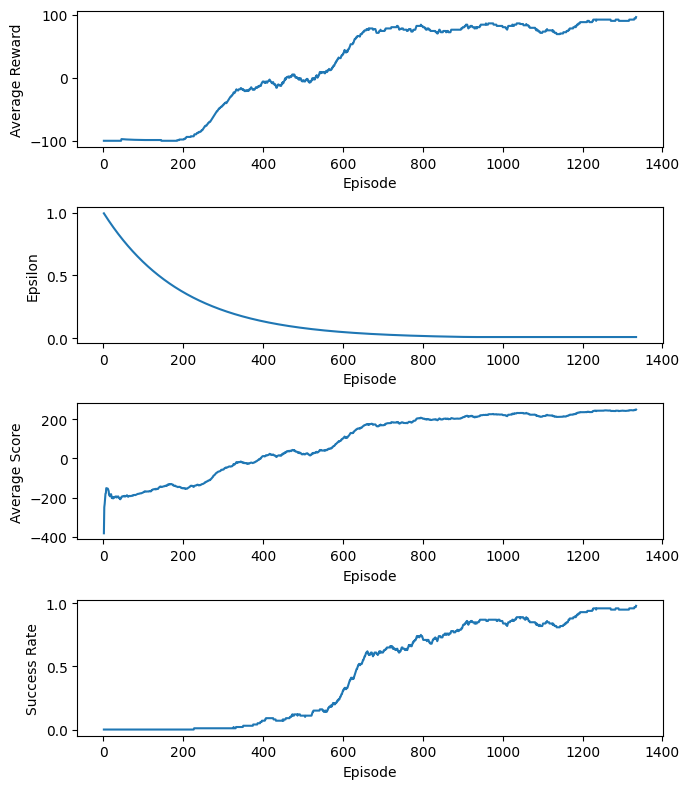

In [9]:
episodes = [item['episode'] for item in scores]
epsilons = [item['epsilon'] for item in scores]
average_score_list = [item['average_score'] for item in scores]
success_rate_list = [item['success_rate'] for item in scores]
average_rewards_list = [item['average_reward'] for item in scores]


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(7,8))

ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward')
ax1.plot(episodes, average_rewards_list)

ax2.set_xlabel('Episode')
ax2.set_ylabel('Epsilon')
ax2.plot(episodes, epsilons)


ax3.set_xlabel('Episode')
ax3.set_ylabel('Average Score')
ax3.plot(episodes, average_score_list)

ax4.set_xlabel('Episode')
ax4.set_ylabel('Success Rate')
ax4.plot(episodes, success_rate_list)


fig.tight_layout()
plt.show()


In [ ]:
agent = Agent(state_size=8, action_size=4, seed=0)
agent.qnetwork_local.load_state_dict(torch.load('saved_models/dqn-hparams.pth'))

env = gym.make('LunarLander-v2', render_mode='human')
state = env.reset()[0]

for _ in range(10000):
    action = agent.act(state, 0)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state

    if done or truncated:
        observation, info = env.reset()

env.close()

# Conclusion

In the study of Lunar Lander v2, two different Deep Q-Network (DQN) models were used: a baseline DQN and a hyperparameter-tuned DQN. The baseline DQN was unable to converge and thus, the training was stopped. This result highlights the crucial role that hyperparameter tuning plays in the successful training of a DQN.

The hyperparameter-tuned DQN, on the other hand, demonstrated significant improvements in performance compared to the baseline DQN. This result supports the idea that even small modifications to the model architecture and training parameters can have a major impact on the overall performance of a DQN. Further research can be conducted to explore other techniques such as double DQN, prioritized replay, and dueling DQN to further enhance the performance of DQN on the Lunar Lander v2 task.

The results from this study can be applied to other reinforcement learning problems, emphasizing the significance of hyperparameter tuning in achieving successful outcomes. This is a crucial step in the development of DQN models for various applications, including robotics, autonomous systems, and gaming. As such, it is important to continue to investigate hyperparameter tuning and its impact on the performance of DQN models.

In conclusion, the study of Lunar Lander v2 has provided valuable insights into the use of DQN in reinforcement learning. The results demonstrate the importance of properly tuning the hyperparameters to achieve optimal performance. Further research is needed to continue to improve the performance of DQN models and make them more widely applicable in various fields. The findings of this study can serve as a useful starting point for future work in this area.